<h1>Installing RDKit</h1>

In [1]:
import rdkit
import deepchem as dc
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn

In [2]:
dc.__version__

'2.5.0'

In [3]:
np.__version__

'1.19.5'

In [4]:
tf.__version__

'2.6.0'

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/saharctech/Binding-Free-Energy-Prediction-Host-Guest-System/master/Results/dataset.csv')
#df = pd.read_csv('/Users/misspotato/Documents/GitHub/Binding-Free-Energy-Prediction-Host-Guest-System/Results/dataset.csv')

In [6]:
df.head()

,dataset group name,Dataset Name,Host,Guest,Ex _G_(kcal/mol),Ex _G_SEM,EX _H_(kcal/mol),EX _H_SEM,entropy,pb_guest_Etot,...,gb_host_1-4EEL,gb_host_EELEC,gb_host_EGB,gb_host_ESURF,gb_delta_H,pb_delta_H,EX _delta_H_(kcal/mol),gb_Ex_difference,SQR_gbnsr6_Ex_difference,pb_Ex_difference
0,Mobley benchmarkset,cd-set1,acd,guest-1,-1.575,0.019,-2.17,0.05,-0.595,-47.8832,...,423.5761,-428.9520,-96.4471,5.1691,-1.9950,-0.8408,-2.17,0.1750,0.030625,1.3292
1,Mobley benchmarkset,cd-set1,acd,guest-2,-3.533,0.004,-4.19,0.02,-0.657,-52.0758,...,412.6663,-397.9784,-106.4154,5.0726,-11.2624,-8.4809,-4.19,-7.0724,50.018842,-4.2909
2,Mobley benchmarkset,cd-set1,acd,guest-3,-4.606,0.007,-5.46,0.03,-0.854,-51.5323,...,426.2925,-429.3068,-95.2452,5.1352,-15.4074,-13.8234,-5.46,-9.9474,98.950767,-8.3634
3,Mobley benchmarkset,cd-set1,acd,guest-4,-2.130,0.016,-2.74,0.02,-0.610,2.3898,...,420.0687,-416.5215,-97.4461,5.0849,-10.5586,-11.3319,-2.74,-7.8186,61.130506,-8.5919
4,Mobley benchmarkset,cd-set1,acd,guest-5,-2.510,0.060,-2.99,0.23,-0.480,-3.2280,...,425.7315,-435.9689,-91.2312,5.0881,-14.5517,-14.0485,-2.99,-11.5617,133.672907,-11.0585


In [7]:
df.columns

Index(['dataset group name', 'Dataset Name', 'Host', 'Guest',
       'Ex _G_(kcal/mol)', 'Ex _G_SEM', 'EX _H_(kcal/mol)', 'EX _H_SEM',
       'entropy', 'pb_guest_Etot', 'pb_guest_VDWAALS', 'pb_guest_EELEC',
       'pb_guest_EPB', 'pb_guest_ECAVITY', 'pb_host_Etot', 'pb_host_VDWAALS',
       'pb_host_EELEC', 'pb_host_EPB', 'pb_host_ECAVITY', 'pb_complex_Etot',
       'pb_complex_VDWAALS', 'pb_complex_EELEC', 'pb_complex_EPB',
       'pb_complex_ECAVITY', 'gb_Complex_Etot', 'gb_Complex_1-4EEL',
       'gb_Complex_EELEC', 'gb_Complex_EGB', 'gb_Complex_ESURF',
       'gb_guest_Etot', 'gb_guest_1-4EEL', 'gb_guest_EELEC', 'gb_guest_EGB',
       'gb_guest_ESURF', 'gb_host_Etot', 'gb_host_1-4EEL', 'gb_host_EELEC',
       'gb_host_EGB', 'gb_host_ESURF', 'gb_delta_H', 'pb_delta_H',
       'EX _delta_H_(kcal/mol)', 'gb_Ex_difference',
       'SQR_gbnsr6_Ex_difference', 'pb_Ex_difference'],
      dtype='object')

<h1>Reading Mobley PDB files</h1>
<p>Here each PDB file will be read and saved in Mol data type defined in RDKit and used by DeepChem</p>

In [8]:
# Dictionary with complex names as keys and molecule as values
PDBs = {}
from os import listdir
from os.path import isfile, join
mypath = '/Users/misspotato/Documents/Github/Binding-Free-Energy-Prediction-Host-Guest-System/PDB'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
for f in onlyfiles:
    PDBs.update({f.split('.')[0].replace('s', '') : rdkit.Chem.rdmolfiles.MolFromPDBFile(mypath + '/' + f)})

In [9]:
# Randomly shuffling the PDBs
import random
l = list(PDBs.items())
random.shuffle(l)
PDBs = dict(l)

<h1>Featurizing</h1>
<p>GraphConv model needs ConvMolFeaturizer</p>

In [10]:
featurizer = dc.feat.ConvMolFeaturizer(per_atom_fragmentation=False)
TRAIN_SET = .7
VAL_SET = .3

In [11]:
PDBs.pop('',None)
X = []
X_ids = []
# one_add = 0 if len(PDBs.keys()) % 2 == 0 else 1
for k in PDBs.keys():
    X_ids.append(k)
    X.append(featurizer.featurize(PDBs[k]))
train_split_index = int(len(X) * TRAIN_SET)
val_split_index = int(len(X) * VAL_SET)
X = [x[0] for x in X]
X_train_featurized = X[:train_split_index]
# X_val_featurized = X[train_split_index: (train_split_index + val_split_index)]
X_val_featurized = X[train_split_index:]
X_test_featurized = X[train_split_index:]

In [12]:
host_names = [i.split('-')[0] for i in X_ids]
guest_names = ['guest-' + (i.split('-')[1].replace('s', '')) for i in X_ids]

In [13]:
# train
host_names_train = host_names[:train_split_index]
guest_names_train = guest_names[:train_split_index]
# Val
# host_names_val = host_names[train_split_index:(train_split_index + val_split_index)]
# guest_names_val = guest_names[train_split_index:(train_split_index + val_split_index)]
host_names_val = host_names[train_split_index:]
guest_names_val = guest_names[train_split_index:]
# test
host_names_test = host_names[train_split_index:]
guest_names_test = guest_names[train_split_index:]


In [14]:
x_add_train, x_add_val, x_add_test, y_train, y_val, y_test = [], [], [], [], [], []
# Train
for i in range(len(host_names_train)):
    new_df = df[(df['Host'] == host_names_train[i]) & (df['Guest'] == guest_names_train[i])]
    y_train.append(new_df['Ex _G_(kcal/mol)'].to_numpy()[0])
    x_add_train.append(new_df[[c for c in df.columns if ('Etot' not in c) and ('delta' not in c)
                         and ('Ex_difference' not in c) and ('entropy' in c or 'gb_' in c or 'VDWAALS' in c)]].to_numpy()[0])
y_train = np.array(y_train)
# Val
for i in range(len(host_names_val)):
    new_df = df[(df['Host'] == host_names_val[i]) & (df['Guest'] == guest_names_val[i])]
    y_val.append(new_df['Ex _G_(kcal/mol)'].to_numpy()[0])
    x_add_val.append(new_df[[c for c in df.columns if ('Etot' not in c) and ('delta' not in c)
                         and ('Ex_difference' not in c) and ('entropy' in c or 'gb_' in c or 'VDWAALS' in c)]].to_numpy()[0])
y_val = np.array(y_val)

# Test
for i in range(len(host_names_test)):
    new_df = df[(df['Host'] == host_names_test[i]) & (df['Guest'] == guest_names_test[i])]
    y_test.append(new_df['Ex _G_(kcal/mol)'].to_numpy()[0])
    x_add_test.append(new_df[[c for c in df.columns if ('Etot' not in c) and ('delta' not in c)
                         and ('Ex_difference' not in c) and ('entropy' in c or 'gb_' in c or 'VDWAALS' in c)]].to_numpy()[0])
y_test = np.array(y_test)

In [15]:
x_add_train

[array([  -0.523 ,   -0.688 ,  -29.2511,  -49.0065,  436.7039, -378.1315,
        -187.9497,    5.166 ,   16.8888,   11.3413,  -66.0705,    1.9472,
         419.815 , -401.3316, -115.9134,    5.1109]),
 array([ 3.027000e+00, -2.220000e-02, -3.456200e+01, -4.786560e+01,
         4.399762e+02, -4.160062e+02, -1.906296e+02,  5.856200e+00,
        -5.083530e+01,  5.293590e+01, -6.282810e+01,  1.879500e+00,
         4.908115e+02, -4.789553e+02, -1.267906e+02,  5.985300e+00]),
 array([ 3.5000000e+00,  1.5257000e+00, -4.9006400e+01, -7.5163700e+01,
        -2.8479638e+03,  1.6967623e+03, -1.6205690e+02,  5.7789000e+00,
        -1.5518500e+01,  3.8735900e+01, -6.0969800e+01,  1.6868000e+00,
        -2.8324453e+03,  1.7263218e+03, -1.7513390e+02,  6.2877000e+00]),
 array([   -5.43  ,    -2.9703,   -41.3311,   -73.5548,   -69.8434,
          923.0019, -1695.4159,     8.0727,    14.3225,     3.4192,
          -75.9349,     1.8464,   -84.1659,   682.5314, -1393.0275,
            8.3952]),
 array([

In [16]:
len(y_val)

22

In [17]:
from deepchem.metrics import to_one_hot
from deepchem.feat.mol_graphs import ConvMol

x_preprocessed_train, x_preprocessed_val, x_preprocessed_test = [], [], []

## for X train
multiConvMol = ConvMol.agglomerate_mols(X_train_featurized)
x_preprocessed_train = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
    x_preprocessed_train.append(multiConvMol.get_deg_adjacency_lists()[i])
x_preprocessed_train.append(np.array(x_add_train))

## for X val
multiConvMol = ConvMol.agglomerate_mols(X_val_featurized)
x_preprocessed_val = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
    x_preprocessed_val.append(multiConvMol.get_deg_adjacency_lists()[i])
x_preprocessed_val.append(np.array(x_add_val))


## for X test
multiConvMol = ConvMol.agglomerate_mols(X_test_featurized)
x_preprocessed_test = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
    x_preprocessed_test.append(multiConvMol.get_deg_adjacency_lists()[i])
x_preprocessed_test.append(np.array(x_add_test))

In [18]:
# Train
x_train = np.full([15, np.max([v.shape[0] for v in x_preprocessed_train]),
                  np.max([v.shape[1] for v in x_preprocessed_train if len(v.shape) > 1])], 1.123456)
for i,j in enumerate(x_preprocessed_train):
    if len(j.shape) > 1:
        x_train[i][:j.shape[0],:j.shape[1]] = np.array(j)
    else:
        x_train[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
x_train = x_train.reshape([1] + list(x_train.shape))

# Validation
x_val = np.full([15, np.max([v.shape[0] for v in x_preprocessed_val]),
                  np.max([v.shape[1] for v in x_preprocessed_val if len(v.shape) > 1])], 1.123456)
for i,j in enumerate(x_preprocessed_val):
    if len(j.shape) > 1:
        x_val[i][:j.shape[0],:j.shape[1]] = np.array(j)
    else:
        x_val[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
x_val = x_val.reshape([1] + list(x_val.shape))

# Test
x_test = np.full([15, np.max([v.shape[0] for v in x_preprocessed_test]),
                  np.max([v.shape[1] for v in x_preprocessed_test if len(v.shape) > 1])], 1.123456)
for i,j in enumerate(x_preprocessed_test):
    if len(j.shape) > 1:
        x_test[i][:j.shape[0],:j.shape[1]] = np.array(j)
    else:
        x_test[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
x_test = x_test.reshape([1] + list(x_test.shape))

In [19]:
x_test.shape

(1, 15, 2054, 75)

<h1>Physics Guided Neural Network Model</h1>

In [20]:
# pgnn_test_accuracy = []
# pgnn_train_accuracy = []

In [21]:
## !!!!!!!! important
## !!!!!!!! important
## !!!!!!!! important
## !!!!!!!! important
batch_size = len(host_names_train)
batch_size
# batch_size=10

50

In [24]:
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Concatenate
from tensorflow.keras import initializers


class GBGraphConvModel(tf.keras.Model):

  def modify_graphgather(self, batch_size):
    self.readout.batch_size = batch_size
    self.batch_size = batch_size
  def __init__(self, batch_size):
    super(GBGraphConvModel, self).__init__()
    self.input_shapes = None
    self.batch_size = batch_size
    self.gc1 = GraphConv(32, activation_fn=tf.nn.tanh)
    self.batch_norm1 = layers.BatchNormalization()
    self.gp1 = GraphPool()

    self.gc2 = GraphConv(32, activation_fn=tf.nn.tanh)
    self.batch_norm2 = layers.BatchNormalization()
    self.gp2 = GraphPool()

    self.dense1 = layers.Dense(64, activation=tf.nn.tanh)
    self.batch_norm3 = layers.BatchNormalization()
    self.readout = GraphGather(batch_size=self.batch_size, activation_fn=tf.nn.tanh)

    self.dense2 = layers.Dense(1)
    self.dense3 = layers.Dense(1, 
         kernel_initializer=initializers.Constant([.5, 0, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1]),
         bias_initializer=initializers.Zeros())

  def call(self, inputs):
    inputs = inputs[0]
    x = []
#     input_shapes = [[4822, 75], [11, 2], [4822], [1142, 1], [1635, 2], [2042, 3],
#                    [3, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10]]
    for i in range(len(self.input_shapes)):
        x.append(tf.reshape(inputs[i][inputs[i] != 1.123456], self.input_shapes[i]))
    for i in range(1, len(self.input_shapes)):
        x[i] = tf.cast(x[i], tf.int32)
    x_add = tf.reshape(inputs[13][inputs[13] != 1.123456], [self.batch_size, 16])
    gc1_output = self.gc1(x)
    batch_norm1_output = self.batch_norm1(gc1_output)
    gp1_output = self.gp1([batch_norm1_output] + x[1:])

    gc2_output = self.gc2([gp1_output] + x[1:])
    batch_norm2_output = self.batch_norm1(gc2_output)
    gp2_output = self.gp2([batch_norm2_output] + x[1:])

    dense1_output = self.dense1(gp2_output)
    batch_norm3_output = self.batch_norm3(dense1_output)
    readout_output = self.readout([batch_norm3_output] + x[1:])
    
    model_var = self.dense2(readout_output)
    binding_affinity = tf.concat([model_var, x_add], axis=1)
    return self.dense3(binding_affinity)
hybrid_model = GBGraphConvModel(train_split_index)
hybrid_model.compile(loss='mse', optimizer='adam')

In [25]:
pgnn_losses, pgnn_val_losses = [], []
max_epoch = 100
val_size = len(y_val)
train_size = len(y_train)

for epoch in range(max_epoch):
    hybrid_model.modify_graphgather(train_size)
    hybrid_model.input_shapes = [i.shape for i in x_preprocessed_train]
    loss = hybrid_model.fit(x_train, y_train.reshape([1, -1]), epochs=1)
#     metric = dc.metrics.Metric(dc.metrics.score_function.rms_score)
    pgnn_losses.append(loss.history['loss'])
    hybrid_model.input_shapes = [i.shape for i in x_preprocessed_val]
    hybrid_model.modify_graphgather(val_size)
    pgnn_val_losses.append(hybrid_model.evaluate(x_val, y_val.reshape([1, -1])))

/Users/misspotato/opt/miniconda3/envs/rdkit-deepchem-jupyter/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gb_graph_conv_model_1/graph_pool_3/Reshape_14:0", shape=(1049,), dtype=int32), values=Tensor("gradient_tape/gb_graph_conv_model_1/graph_pool_3/Reshape_13:0", shape=(1049, 32), dtype=float32), dense_shape=Tensor("gradient_tape/gb_graph_conv_model_1/graph_pool_3/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/Users/misspotato/opt/miniconda3/envs/rdkit-deepchem-jupyter/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gb_graph_conv_model_1/graph_pool_3/Reshape_17:0", shape=(3634,), dtype=int32), values=Tensor("gradient_tape/gb_graph_conv_model_1/graph_pool_3/Resh

1/1 [==============================] - 0s 31ms/step - loss: 30.1226


1/1 [==============================] - 0s 33ms/step - loss: 28.4509


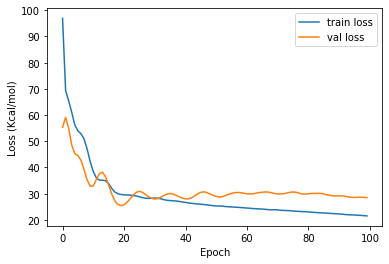

In [26]:
import matplotlib.pyplot as plt
# f, ax = plt.subplots()
plt.plot(range(len(pgnn_losses)), pgnn_losses, label='train loss')
plt.plot(range(len(pgnn_val_losses)), pgnn_val_losses, label='val loss')
plt.legend(loc='upper right');
plt.xlabel("Epoch")
plt.ylabel("Loss (Kcal/mol)")
plt.savefig('comb_loss.png')

In [27]:
hybrid_model.input_shapes = [i.shape for i in x_preprocessed_test]
hybrid_model.modify_graphgather(len(y_test))

In [28]:
evalu = hybrid_model.evaluate(x_test, y_test.reshape([1, -1]))

1/1 [==============================] - 0s 28ms/step - loss: 28.4509


In [29]:
pgnn_rmse_test = np.sqrt(evalu)
print(pgnn_rmse_test)

5.333936458499534


In [30]:
train_loss = pgnn_losses[-1]

In [31]:
import math
train_hybrid_rmse = math.sqrt(train_loss[0])
train_hybrid_rmse

4.634346256179826

In [853]:
pgnn_test_accuracy.append(pgnn_rmse_test)
pgnn_train_accuracy.append(train_hybrid_rmse)

In [854]:
print(pgnn_test_accuracy)

[4.247915991158998, 4.35898908322064, 6.944077955959831, 6.510748852202416, 5.414611524347312, 5.933509208272808, 4.313666365638178, 4.970641537867484, 5.242358140968035, 6.948171569937173, 6.618310393952759, 4.790422206102478]


<h1> Physics based model RMSE </h1>

In [36]:
import math
train_sum=0
for i in range(len(host_names_train)):
    new_df = df[(df['Host'] == host_names_train[i]) & (df['Guest'] == guest_names_train[i])]
    train_sum += new_df['gb_Ex_difference'].to_numpy()[0] **2


test_sum = 0
for i in range(len(host_names_test)):
    new_df = df[(df['Host'] == host_names_test[i]) & (df['Guest'] == guest_names_test[i])]
    test_sum += new_df['gb_Ex_difference'].to_numpy()[0] **2
    

In [37]:
physics_based_rmse_train = math.sqrt(train_sum / len(host_names_train))

In [38]:
physics_based_rmse_test = math.sqrt((test_sum) / len(host_names_test))

In [47]:
print(f"RMSE on training set is : {physics_based_rmse_train}")
print(f"RMSE on testing set is : {physics_based_rmse_test}")
# Total rmse
total_rmse_physics = np.sqrt(np.mean((df['EX _H_(kcal/mol)'].to_numpy() - df['gb_delta_H'].to_numpy())**2))
print(f"RMSE of the total data: {total_rmse_physics}")

RMSE on training set is : 9.566673166822417
RMSE on testing set is : 7.9998636043486275
RMSE of the total data: 9.116540038105953


In [13]:
# RMSE gbnsr6 vs experimental
from sklearn.metrics import mean_squared_error
import math
mse_gb_ex = mean_squared_error(df['EX _delta_H_(kcal/mol)'], df['gb_delta_H'])
rmse_gbnsr6_ex = math.sqrt(mse_gb_ex)
print(rmse_gbnsr6_ex)

9.116540038105953


In [14]:
# RMSE pbsa vs experimental
mse_pb_ex = mean_squared_error(df['EX _delta_H_(kcal/mol)'], df['pb_delta_H'])
rmse_pbsa_ex = math.sqrt(mse_pb_ex)
print(rmse_pbsa_ex)

7.662234345322445


In [15]:
# RMSE gbnsr6 vs pbsa
mse_gb_pb = mean_squared_error(df['pb_delta_H'], df['gb_delta_H'])
rmse_gb_pb = math.sqrt(mse_gb_pb)
print(rmse_gb_pb)

2.482988596122065


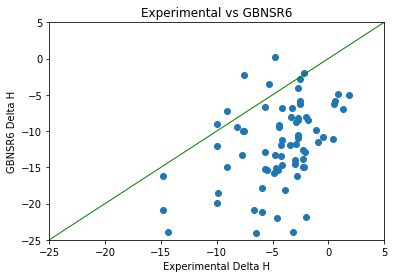

In [48]:
import matplotlib.pyplot as plt

plt.title("Experimental vs GBNSR6")
plt.scatter(x=df['EX _H_(kcal/mol)'], y=df['gb_delta_H'])
plt.xlabel("Experimental Delta H")
plt.ylabel("GBNSR6 Delta H")
plt.xlim(-25, 5)
plt.ylim(-25,5)

#reference line
plt.plot([-25, 5], [-25, 5], color='green', lw=1)

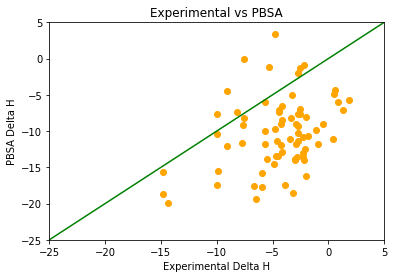

In [49]:
plt.title("Experimental vs PBSA")
plt.scatter(x=df['EX _H_(kcal/mol)'] ,y=df['pb_delta_H'], color='orange')
plt.xlabel("Experimental Delta H")
plt.ylabel("PBSA Delta H")
plt.xlim(-25, 5)
plt.ylim(-25,5)
#reference line
plt.plot([-25,5],[-25,5], color='green')

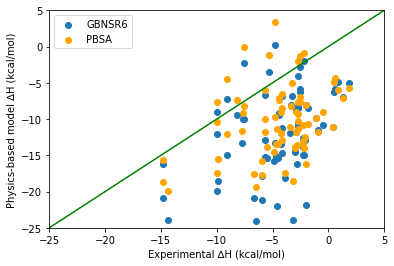

In [77]:
ax = plt.subplot()
# plt.title("PBSA vs GBNSR6")
plt.xlabel('Experimental ∆H (kcal/mol)')
plt.ylabel('Physics-based model ∆H (kcal/mol)')
ax.scatter(x=df["EX _H_(kcal/mol)"], y=df['gb_delta_H'], label="GBNSR6")
ax.scatter(x=df["EX _H_(kcal/mol)"], y=df['pb_delta_H'], label="PBSA", color="orange")
plt.xlim(-25,5)
plt.ylim(-25,5)
#reference line
plt.plot([-25,5],[-25,5],color='green')
plt.legend()
plt.savefig('gb-pb.png')

In [51]:
gb_correlation_matrix = np.corrcoef(df['gb_delta_H'], df['EX _H_(kcal/mol)'])
gb_correlation_gbex = gb_correlation_matrix[0,1]
gb_r_squared = gb_correlation_gbex**2
print(gb_r_squared)

0.16443424102892118


In [52]:
pb_correlation_matrix = np.corrcoef(df['pb_delta_H'], df['EX _H_(kcal/mol)'])
pb_correlation_pbex = pb_correlation_matrix[0,1]
pb_r_squared = pb_correlation_pbex**2
print(pb_r_squared)

0.1098144445778738


In [17]:
pbgb_correlation_matrix = np.corrcoef(df['gb_delta_H'], df['pb_delta_H'])
pbgb_correlation = pbgb_correlation_matrix[0,1]
pbgb_r_squared = pbgb_correlation**2
print(pbgb_r_squared)

0.8901482846824414


<h1> Data Driven Model </h1>

In [855]:
## !!!!!!!! important
## !!!!!!!! important
## !!!!!!!! important
## !!!!!!!! important
input_shapes = [i.shape for i in x_preprocessed_train]

In [856]:
# dd_test_accuracy = []
# dd_train_accuracy = []

In [857]:
batch_size = len(host_names_train)
batch_size
# batch_size=10

50

In [858]:
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Concatenate
from tensorflow.keras import initializers

# batch_size = int(len(df) / 2)

class GBGraphConvModel(tf.keras.Model):
   
    def modify_graphgather(self, batch_size):
        self.readout.batch_size = batch_size
        self.batch_size = batch_size

    def __init__(self, batch_size):
        super(GBGraphConvModel, self).__init__()
        self.input_shapes = None
        self.batch_size = batch_size
        self.gc1 = GraphConv(32, activation_fn=tf.nn.tanh)
        self.batch_norm1 = layers.BatchNormalization()
        self.gp1 = GraphPool()

        self.gc2 = GraphConv(32, activation_fn=tf.nn.tanh)
        self.batch_norm2 = layers.BatchNormalization()
        self.gp2 = GraphPool()

        self.dense1 = layers.Dense(64, activation=tf.nn.tanh)
        self.batch_norm3 = layers.BatchNormalization()
        self.readout = GraphGather(batch_size=self.batch_size, activation_fn=tf.nn.tanh)

        self.dense2 = layers.Dense(1)
    #     self.dense3 = layers.Dense(1, 
    #          kernel_initializer=initializers.Constant([.5, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1]),
    #          bias_initializer=initializers.Zeros())

    def call(self, inputs):
        inputs = inputs[0]
        x = []
    #     input_shapes = [[4822, 75], [11, 2], [4822], [1142, 1], [1635, 2], [2042, 3],
    #                    [3, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10]]
        for i in range(len(self.input_shapes)):
            x.append(tf.reshape(inputs[i][inputs[i] != 1.123456], self.input_shapes[i]))
        for i in range(1, len(self.input_shapes)):
            x[i] = tf.cast(x[i], tf.int32)
        x_add = tf.reshape(inputs[13][inputs[13] != 1.123456], [self.batch_size, 15])
        gc1_output = self.gc1(x)
        batch_norm1_output = self.batch_norm1(gc1_output)
        gp1_output = self.gp1([batch_norm1_output] + x[1:])

        gc2_output = self.gc2([gp1_output] + x[1:])
        batch_norm2_output = self.batch_norm1(gc2_output)
        gp2_output = self.gp2([batch_norm2_output] + x[1:])

        dense1_output = self.dense1(gp2_output)
        batch_norm3_output = self.batch_norm3(dense1_output)
        readout_output = self.readout([batch_norm3_output] + x[1:])

        model_var = self.dense2(readout_output)
    #     binding_affinity = tf.concat([model_var, x_add], axis=1)
        return model_var #self.dense3(binding_affinity)
dd_model = GBGraphConvModel(train_split_index)
dd_model.compile(loss='mse', optimizer='adam')

In [859]:
dd_losses, dd_val_losses = [], []
max_epoch = 100
val_size = len(y_val)
train_size = len(y_train)

for epoch in range(max_epoch):
    dd_model.modify_graphgather(train_size)
    dd_model.input_shapes = [i.shape for i in x_preprocessed_train]
    loss = dd_model.fit(x_train, y_train.reshape([1, -1]), epochs=1)
#     metric = dc.metrics.Metric(dc.metrics.score_function.rms_score)
    dd_losses.append(loss.history['loss'])
    dd_model.input_shapes = [i.shape for i in x_preprocessed_val]
    dd_model.modify_graphgather(val_size)
    dd_val_losses.append(dd_model.evaluate(x_val, y_val.reshape([1, -1])))

/Users/misspotato/opt/miniconda3/envs/rdkit-deepchem-jupyter/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gb_graph_conv_model_49/graph_pool_99/Reshape_14:0", shape=(1057,), dtype=int32), values=Tensor("gradient_tape/gb_graph_conv_model_49/graph_pool_99/Reshape_13:0", shape=(1057, 32), dtype=float32), dense_shape=Tensor("gradient_tape/gb_graph_conv_model_49/graph_pool_99/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/Users/misspotato/opt/miniconda3/envs/rdkit-deepchem-jupyter/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gb_graph_conv_model_49/graph_pool_99/Reshape_17:0", shape=(3502,), dtype=int32), values=Tensor("gradient_tape/gb_graph_conv_model_49/graph_po

1/1 [==============================] - 0s 32ms/step - loss: 12.1941


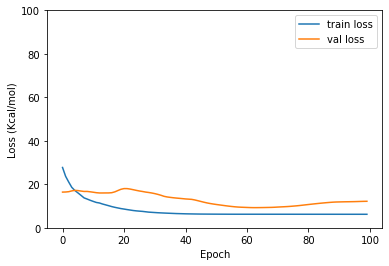

In [860]:
import matplotlib.pyplot as plt
# f, ax = plt.subplots()
plt.plot(range(len(dd_losses)), dd_losses, label='train loss')
plt.plot(range(len(dd_val_losses)), dd_val_losses, label='val loss')
plt.legend(loc='upper right');
plt.xlabel("Epoch")
plt.ylabel("Loss (Kcal/mol)")
plt.ylim(0,100)
plt.savefig('ind_loss.png')

In [861]:
dd_model.input_shapes = [i.shape for i in x_preprocessed_test]
dd_model.modify_graphgather(len(y_test))
test_pgnn_loss = dd_model.evaluate(x_test, y_test.reshape([1, -1]))

1/1 [==============================] - 0s 37ms/step - loss: 12.1941


In [862]:
dd_rmse_test = np.sqrt(test_pgnn_loss)
print(dd_rmse_test)

3.4920012490531374


In [863]:
dd_train_loss = dd_losses[-1]
dd_train_loss

[6.21751594543457]

In [864]:
import math
train_dd_rmse = math.sqrt(dd_train_loss[0])
train_dd_rmse

2.4934947253673045

In [865]:
dd_test_accuracy.append(dd_rmse_test)
dd_train_accuracy.append(train_dd_rmse)

In [866]:
print(dd_test_accuracy)

[2.7476471459067344, 2.235096528189762, 2.450360727028965, 1.172321590522769, 3.5912934241373193, 2.7393148215714285, 2.6855213954757207, 2.295871022140655, 3.5633989504942187, 2.3038956655813476, 1.493962375754382, 3.4920012490531374]


<h1> Model Comparisons </h1>

In [730]:
# Test
from prettytable import PrettyTable
rmse_table = PrettyTable()
rmse_table.title="Test Set RMSE"
rmse_table.field_names = ["GBNSR6", "Data Driven", "PGNN"]
rmse_table.add_row(["{:.2f}".format(physics_based_rmse_test), "{:.2f}".format(dd_rmse_test),"{:.2f}".format(pgnn_rmse_test)])
print(rmse_table)

NameError: name 'physics_based_rmse_test' is not defined

In [94]:
# Train
rmse_table = PrettyTable()
rmse_table.title="Train Set RMSE"
rmse_table.field_names = ["GBNSR6", "Data Driven", "PGNN"]
rmse_table.add_row(["{:.2f}".format(physics_based_rmse_train), "{:.2f}".format(train_dd_rmse),"{:.2f}".format(train_hybrid_rmse)])
print(rmse_table)

+-----------------------------+
|        Train Set RMSE       |
+--------+-------------+------+
| GBNSR6 | Data Driven | PGNN |
+--------+-------------+------+
|  9.17  |     1.94    | 3.79 |
+--------+-------------+------+


<h1> PGNN and DD model average performance analysis </h1>

In [867]:
train_results_dict = {
    "pgnn_train" : [x for x in pgnn_train_accuracy],
    "dd_train" : [x for x in dd_train_accuracy]
}
test_results_dict ={
    "pgnn_test" : [x for x in pgnn_test_accuracy],
    "dd_test" : [x for x in dd_test_accuracy]
}

(2.0, 5.0)

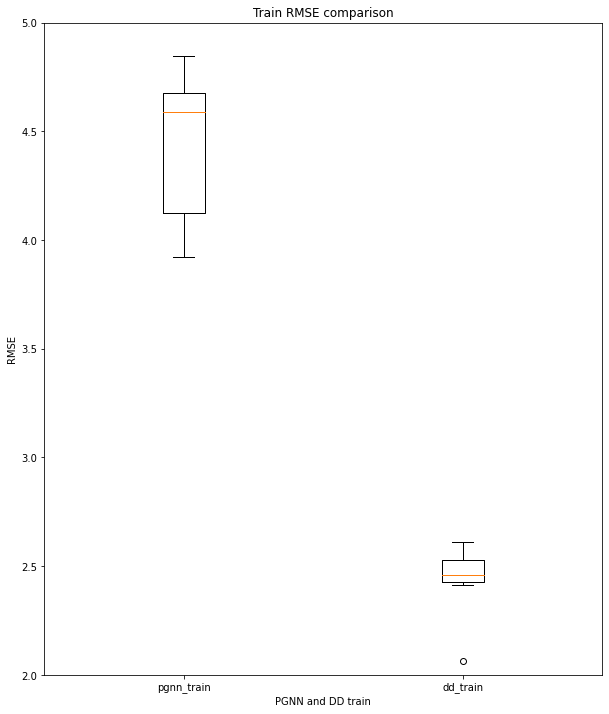

In [883]:
import matplotlib.pyplot as plt
# Train box plot
plt.figure(figsize=(10,12))
plt.title("Train RMSE comparison")
plt.boxplot([x for x in train_results_dict.values()],labels=[x for x in train_results_dict.keys()])
plt.xlabel("PGNN and DD train")
plt.ylabel("RMSE")
plt.ylim(2, 5, 0.3)


(0.0, 8.0)

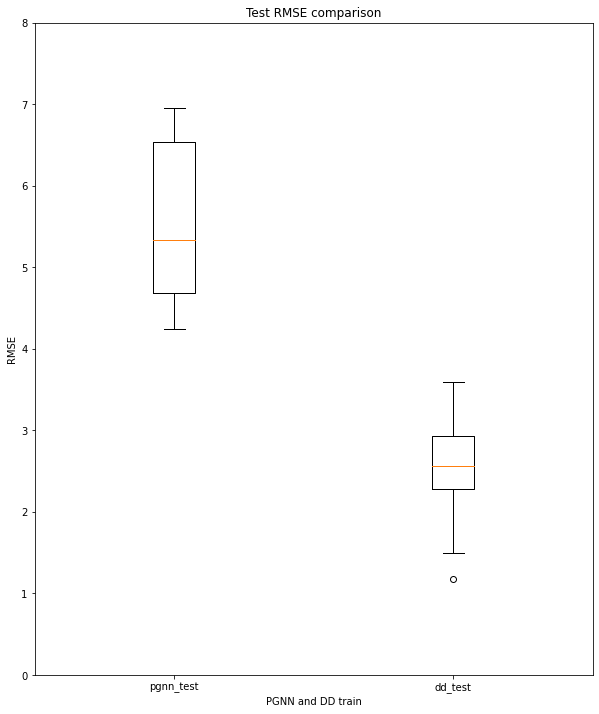

In [884]:
import matplotlib.pyplot as plt
# Test box plot
plt.figure(figsize=(10,12))
plt.title("Test RMSE comparison")
plt.boxplot([x for x in test_results_dict.values()],labels=[x for x in test_results_dict.keys()])
plt.xlabel("PGNN and DD train")
plt.ylabel("RMSE")
plt.ylim(0, 8, 0.3)

